In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#credits
#https://github.com/nikhilroxtomar/Polyp-Segmentation-using-UNET-in-TensorFlow-2.0
#Podziękowania dla pani mgr Agnieszki Pocha z Instytutu Informatyki i Matematyki Komputerowej 
#(Wydział Matematyki i Informatyki UJ, Katedra Uczenia Maszynowego) za pomoc w implementacji sieci neuronowej z optymalizacją hiperparametrów.

In [ ]:
#!unrar x "/content/drive/My Drive/mouse_dataset.rar" "drive/My Drive"

In [ ]:
#DATA

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

In [ ]:
def load_data(path, split=0.2):
    images = sorted(glob(os.path.join(path, "/content/drive/My Drive/mouse_dataset/guz_jpg/*")))
    masks = sorted(glob(os.path.join(path, "/content/drive/My Drive/mouse_dataset/maska_jpg/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
def read_image(path):
     path = path.decode()
     x = cv2.imread(path, cv2.IMREAD_COLOR)
     x = cv2.resize(x, (256, 256))
     x = x/255.0
     return x

In [ ]:
def read_mask(path):
     path = path.decode()
     x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
     x = cv2.resize(x, (256, 256))
     x = x/255.0
     x = np.expand_dims(x, axis=-1)
     return x

In [ ]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([256, 256, 3])
    y.set_shape([256, 256, 1])
    return x, y

def tf_dataset(x, y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [ ]:
#MODEL

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [ ]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [ ]:
def build_model():
    size = 256
    num_filters = [32, 64, 128, 256, 512]
    inputs = Input((size, size, 3))

    skip_x = []
    x = inputs

    ## Encoder
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)

    ## Bridge
    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()

    ## Decoder
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = conv_block(x, f)

    ## Output
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    return Model(inputs, x)

In [ ]:
#TRAIN

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard

In [ ]:
def iou(y_true, y_pred):
     def f(y_true, y_pred):
         intersection = (y_true * y_pred).sum()
         union = y_true.sum() + y_pred.sum() - intersection
         x = (intersection + 1e-15) / (union + 1e-15)
         x = x.astype(np.float32)
         return x
         
     return tf.numpy_function(f, [y_true, y_pred], tf.float32)

In [ ]:
if __name__ == "__main__":
     ## Dataset
     path = "/content/drive/My Drive/mouse_dataset/"
     (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)

In [ ]:
# loss="binary_crossentropy"

# learning_rates = [1e-4, 1e-3, 1e-5]
# diff_num_filters = [[16, 32, 48, 64], [32, 64, 128, 256], [32, 64, 128, 256, 512]]
# batches = [4, 8, 16, 32]
# diff_epochs = [100]
# size = 256

# best_hparams = None
# best_loss = sys.maxsize

# for lr in learning_rates:
#   for num_filters in diff_num_filters:
#     for batch in batches:
#       for epochs in diff_epochs:
#         (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
#         train_dataset = tf_dataset(train_x, train_y, batch=batch)
#         valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)
#         train_steps = len(train_x)//batch
#         valid_steps = len(valid_x)//batch

#         if len(train_x) % batch != 0:
#             train_steps += 1
#         if len(valid_x) % batch != 0:
#             valid_steps += 1


#         identyfikator=str(time.time())
#         print(identyfikator)
#         print(f"lr={lr}, num_filters={num_filters}, batch={batch}, epochs={epochs}, size={size}")

#         model=build_and_compile(size, num_filters, lr, loss)
        

#         callbacks = [
#               ModelCheckpoint(f"/content/drive/My Drive/mouse_dataset/files/model-{identyfikator}.h5"),
#               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
#               CSVLogger(f"/content/drive/My Drive/mouse_dataset/files/data-{identyfikator}.csv"),
#               TensorBoard(),
#               EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#         ]

#         history=train(batch, train_x, valid_x, train_dataset, valid_dataset, model, epochs, callbacks)
#         with open(f'/content/drive/My Drive/mouse_dataset/hist/hist-{identyfikator}', 'wb') as file_pi:
#           pickle.dump(history.history, file_pi)
#         val_loss=min(history.history['val_loss'])
#         if best_hparams is None or val_loss < best_loss:
#             best_hparams = (lr, num_filters, batch,  epochs, size)
#             best_loss = val_loss
#         print(f"validation loss: {val_loss} for lr={lr}, num_filters={num_filters}, batch={batch}, epochs={epochs}, size={size}")
#         print(f"best hparams: {best_hparams}")

# print(f"/content/drive/My Drive/mouse_dataset/files/model-{identyfikator}.h5")
# print(f"best hparams: {best_hparams}")

In [ ]:
## Hyperparameters

# najlepsza architektura wyłoniona z 'hyperparameters tuning':

# best hparams: (0.001, [32, 64, 128, 256, 512], 4, 70, 256)
# /content/drive/My Drive/mouse_dataset/files/model-1621109156.8693182.h5
# 1621110217.655524

batch = 4
lr = 0.001
epochs = 70

In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

In [ ]:
model = build_model()
opt = tf.keras.optimizers.Adam(lr)
metrics = ["acc", tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), iou]
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)

In [ ]:
callbacks = [
          ModelCheckpoint("/content/drive/My Drive/mouse_dataset/best archi/files/model.h5"),
          ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
          CSVLogger("/content/drive/My Drive/mouse_dataset/best archi/files/data.csv"),
          TensorBoard(),
          EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
     ]

In [ ]:
train_steps = len(train_x)//batch
valid_steps = len(valid_x)//batch

if len(train_x) % batch != 0:
    train_steps += 1
if len(valid_x) % batch != 0:
    valid_steps += 1

history = model.fit(train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks)

Epoch 1/70
85/85 [==============================] - 257s 3s/step - loss: 0.3820 - acc: 0.8631 - recall: 0.7082 - precision: 0.3403 - iou: 0.1462 - val_loss: 550.5726 - val_acc: 0.0661 - val_recall: 1.0000 - val_precision: 0.0541 - val_iou: 0.0539
Epoch 2/70
85/85 [==============================] - 14s 165ms/step - loss: 0.1229 - acc: 0.9752 - recall: 0.7780 - precision: 0.7996 - iou: 0.2923 - val_loss: 13.5179 - val_acc: 0.4014 - val_recall: 0.8748 - val_precision: 0.0732 - val_iou: 0.0683
Epoch 3/70
85/85 [==============================] - 14s 165ms/step - loss: 0.0876 - acc: 0.9767 - recall: 0.7707 - precision: 0.8251 - iou: 0.3827 - val_loss: 0.3773 - val_acc: 0.8253 - val_recall: 0.8170 - val_precision: 0.2099 - val_iou: 0.1735
Epoch 4/70
85/85 [==============================] - 14s 163ms/step - loss: 0.0704 - acc: 0.9783 - recall: 0.7851 - precision: 0.8386 - iou: 0.4483 - val_loss: 23.6146 - val_acc: 0.3794 - val_recall: 0.9556 - val_precision: 0.0763 - val_iou: 0.0750
Epoch 5/70

In [ ]:
#PREDICT

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from tqdm import tqdm

In [ ]:
def read_image(path):
     x = cv2.imread(path, cv2.IMREAD_COLOR)
     x = cv2.resize(x, (256, 256))
     x = x/255.0
     return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = np.expand_dims(x, axis=-1)
    return x

In [ ]:
def mask_parse(mask):
     mask = np.squeeze(mask)
     mask = [mask, mask, mask]
     mask = np.transpose(mask, (1, 2, 0))
     return mask

In [ ]:
if __name__ == "__main__":
     ## Dataset
     path = "/content/drive/My Drive/mouse_dataset/"
     batch_size = 4
     (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)

In [ ]:
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

test_steps = (len(test_x)//batch_size)
if len(test_x) % batch_size != 0:
    test_steps += 1

In [ ]:
 from sklearn.metrics import confusion_matrix  
 import numpy as np

 def compute_iou(y_pred, y_true):
     # ytrue, ypred is a flatten vector
     y_pred = y_pred.flatten()
     y_true = y_true.flatten()
     current = confusion_matrix(y_true, y_pred, labels=[0, 1])
     # compute mean iou
     intersection = np.diag(current)
     ground_truth_set = current.sum(axis=1)
     predicted_set = current.sum(axis=0)
     union = ground_truth_set + predicted_set - intersection
     IoU = intersection / union.astype(np.float32)
     return np.mean(IoU)

In [ ]:
with CustomObjectScope({'iou': iou}):
    model = tf.keras.models.load_model("/content/drive/My Drive/mouse_dataset/best archi/files/model.h5")

In [ ]:
for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
          x = read_image(x)
          y = read_mask(y)
          y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
          h, w, _ = x.shape
          white_line = np.ones((h, 10, 3)) * 255.0
          all_images = [
            x * 255.0, white_line,
            mask_parse(y), white_line,
            mask_parse(y_pred) * 255.0
          ]
          image = np.concatenate(all_images, axis=1)
          x_255=x*255.0
          cv2.imwrite(f"/content/drive/My Drive/mouse_dataset/best archi/testGT/{i}.jpg", y)
          cv2.imwrite(f"/content/drive/My Drive/mouse_dataset/best archi/testInput/{i}.jpg", x_255)  
          # cv2.imwrite(f"/content/drive/My Drive/mouse_dataset/testOutput/{i}.jpg", y_pred)                 
          cv2.imwrite(f"/content/drive/My Drive/mouse_dataset/best archi/results/{i}.jpg", image)
          iou_=compute_iou(y, y_pred)
          print(iou_)

  1%|          | 1/113 [00:00<00:27,  4.05it/s]

0.507946957057


  2%|▏         | 2/113 [00:00<00:27,  4.08it/s]

0.5100138907360612


  3%|▎         | 3/113 [00:00<00:27,  4.05it/s]

0.5144000357060572


  4%|▎         | 4/113 [00:00<00:26,  4.07it/s]

0.49584285297098585


  4%|▍         | 5/113 [00:01<00:30,  3.56it/s]

0.5038441885737047


  5%|▌         | 6/113 [00:01<00:28,  3.72it/s]

0.4999686917862901


  6%|▌         | 7/113 [00:01<00:28,  3.78it/s]

0.4929668517228166


  7%|▋         | 8/113 [00:02<00:27,  3.84it/s]

0.5080038352599049


  8%|▊         | 9/113 [00:02<00:26,  3.87it/s]

0.5001077585360084


  9%|▉         | 10/113 [00:02<00:26,  3.95it/s]

0.5028102908988608


 10%|▉         | 11/113 [00:02<00:25,  3.93it/s]

0.5044189328913032


 11%|█         | 12/113 [00:03<00:25,  3.95it/s]

0.562443859874246


 12%|█▏        | 13/113 [00:03<00:24,  4.01it/s]

0.5017934908674127


 12%|█▏        | 14/113 [00:03<00:24,  4.02it/s]

0.502386940592349


 13%|█▎        | 15/113 [00:03<00:24,  4.02it/s]

0.5001486162834162


 14%|█▍        | 16/113 [00:04<00:23,  4.06it/s]

0.5034837981152124


 15%|█▌        | 17/113 [00:04<00:23,  4.02it/s]

0.5019019155751893


 16%|█▌        | 18/113 [00:04<00:27,  3.45it/s]

0.4999360327512314


 17%|█▋        | 19/113 [00:04<00:26,  3.59it/s]

0.4964079866558769


 18%|█▊        | 20/113 [00:05<00:25,  3.65it/s]

0.4995203055461193


 19%|█▊        | 21/113 [00:05<00:24,  3.77it/s]

0.5014636209686373


 19%|█▉        | 22/113 [00:05<00:23,  3.86it/s]

0.4931191974629049


 20%|██        | 23/113 [00:05<00:23,  3.80it/s]

0.5027041576178422


 21%|██        | 24/113 [00:06<00:26,  3.32it/s]

0.5033194929618222


 22%|██▏       | 25/113 [00:06<00:24,  3.54it/s]

0.4992405253853023


 23%|██▎       | 26/113 [00:06<00:23,  3.65it/s]

0.493813703662944


 24%|██▍       | 27/113 [00:07<00:22,  3.77it/s]

0.5028320734645769


 25%|██▍       | 28/113 [00:07<00:22,  3.80it/s]

0.4986913963673163


 26%|██▌       | 29/113 [00:07<00:22,  3.77it/s]

0.4989163775298659


 27%|██▋       | 30/113 [00:08<00:24,  3.36it/s]

0.49690567090284676


 27%|██▋       | 31/113 [00:08<00:23,  3.57it/s]

0.49965395139224206


 28%|██▊       | 32/113 [00:08<00:21,  3.71it/s]

0.49912355505021794


 29%|██▉       | 33/113 [00:08<00:20,  3.82it/s]

0.5122231694266591


 30%|███       | 34/113 [00:09<00:21,  3.75it/s]

0.49056166728980116


 31%|███       | 35/113 [00:09<00:20,  3.80it/s]

0.5116494758438492


 32%|███▏      | 36/113 [00:09<00:22,  3.38it/s]

0.5050060413219843


 33%|███▎      | 37/113 [00:09<00:21,  3.53it/s]

0.5311283237885105


 34%|███▎      | 38/113 [00:10<00:20,  3.58it/s]

0.48926148792101926


 35%|███▍      | 39/113 [00:10<00:19,  3.72it/s]

0.4873708690037783


 35%|███▌      | 40/113 [00:10<00:19,  3.80it/s]

0.49636011244658995


 36%|███▋      | 41/113 [00:10<00:18,  3.85it/s]

0.49995308614946754


 37%|███▋      | 42/113 [00:11<00:19,  3.63it/s]

0.5008803602306485


 38%|███▊      | 43/113 [00:11<00:18,  3.75it/s]

0.5018830289234978


 39%|███▉      | 44/113 [00:11<00:18,  3.71it/s]

0.49739096824067514


 40%|███▉      | 45/113 [00:12<00:17,  3.78it/s]

0.49699581392069536


 41%|████      | 46/113 [00:12<00:17,  3.85it/s]

0.49698276925626744


 42%|████▏     | 47/113 [00:12<00:16,  3.90it/s]

0.4993458695206721


 42%|████▏     | 48/113 [00:12<00:19,  3.36it/s]

0.5040584901245414


 43%|████▎     | 49/113 [00:13<00:18,  3.54it/s]

0.49875096230891297


 44%|████▍     | 50/113 [00:13<00:17,  3.64it/s]

0.5058162831585155


 45%|████▌     | 51/113 [00:13<00:16,  3.75it/s]

0.4944302394397427


 46%|████▌     | 52/113 [00:13<00:16,  3.81it/s]

0.503355427746112


 47%|████▋     | 53/113 [00:14<00:15,  3.85it/s]

0.4994890338809842


 48%|████▊     | 54/113 [00:14<00:18,  3.25it/s]

0.4987250675210951


 49%|████▊     | 55/113 [00:14<00:16,  3.44it/s]

0.4985925017298861


 50%|████▉     | 56/113 [00:15<00:15,  3.57it/s]

0.4828347441967659


 50%|█████     | 57/113 [00:15<00:15,  3.69it/s]

0.46996067920717494


 51%|█████▏    | 58/113 [00:15<00:14,  3.80it/s]

0.49578358306963444


 52%|█████▏    | 59/113 [00:15<00:13,  3.89it/s]

0.501553053089591


 53%|█████▎    | 60/113 [00:16<00:14,  3.62it/s]

0.49864005711760107


 54%|█████▍    | 61/113 [00:16<00:13,  3.73it/s]

0.49965943218056286


 55%|█████▍    | 62/113 [00:16<00:13,  3.73it/s]

0.5148688246446157


 56%|█████▌    | 63/113 [00:16<00:13,  3.81it/s]

0.4923038457331271


 57%|█████▋    | 64/113 [00:17<00:12,  3.87it/s]

0.4996589469581317


 58%|█████▊    | 65/113 [00:17<00:12,  3.90it/s]

0.4978610554231322


 58%|█████▊    | 66/113 [00:17<00:11,  3.92it/s]

0.49927984205075093


 59%|█████▉    | 67/113 [00:17<00:11,  3.94it/s]

0.49678168585913807


 60%|██████    | 68/113 [00:18<00:12,  3.69it/s]

0.49710890768667176


 61%|██████    | 69/113 [00:18<00:11,  3.67it/s]

0.4985526421896651


 62%|██████▏   | 70/113 [00:18<00:11,  3.79it/s]

0.49723730360832175


 63%|██████▎   | 71/113 [00:19<00:11,  3.79it/s]

0.49917644801228134


 64%|██████▎   | 72/113 [00:19<00:10,  3.79it/s]

0.5030159042570077


 65%|██████▍   | 73/113 [00:19<00:10,  3.86it/s]

0.5006831150044202


 65%|██████▌   | 74/113 [00:19<00:09,  3.95it/s]

0.47876124647815355


 66%|██████▋   | 75/113 [00:20<00:09,  3.96it/s]

0.5019080549473954


 67%|██████▋   | 76/113 [00:20<00:09,  3.89it/s]

0.4999754263527793


 68%|██████▊   | 77/113 [00:20<00:10,  3.35it/s]

0.49933779061417927


 69%|██████▉   | 78/113 [00:20<00:09,  3.53it/s]

0.5071313273792105


 70%|██████▉   | 79/113 [00:21<00:09,  3.65it/s]

0.49977493797358713


 71%|███████   | 80/113 [00:21<00:09,  3.64it/s]

0.4988449671259874


 72%|███████▏  | 81/113 [00:21<00:08,  3.75it/s]

0.5051884989158809


 73%|███████▎  | 82/113 [00:21<00:08,  3.78it/s]

0.5006912747864624


 73%|███████▎  | 83/113 [00:22<00:08,  3.75it/s]

0.5042442392131404


 74%|███████▍  | 84/113 [00:22<00:07,  3.77it/s]

0.49904572564612326


 75%|███████▌  | 85/113 [00:22<00:07,  3.81it/s]

0.5019028140444037


 76%|███████▌  | 86/113 [00:23<00:07,  3.71it/s]

0.5025407028857607


 77%|███████▋  | 87/113 [00:23<00:06,  3.79it/s]

0.49829308581766696


 78%|███████▊  | 88/113 [00:23<00:06,  3.76it/s]

0.501452081405892


 79%|███████▉  | 89/113 [00:23<00:06,  3.45it/s]

0.5213805088457629


 80%|███████▉  | 90/113 [00:24<00:06,  3.52it/s]

0.4964678682251192


 81%|████████  | 91/113 [00:24<00:06,  3.58it/s]

0.48624988920165874


 81%|████████▏ | 92/113 [00:24<00:05,  3.66it/s]

0.4956280241935484


 82%|████████▏ | 93/113 [00:24<00:05,  3.73it/s]

0.5084921219750856


 83%|████████▎ | 94/113 [00:25<00:05,  3.77it/s]

0.5025864411636823


 84%|████████▍ | 95/113 [00:25<00:04,  3.85it/s]

0.5037885093003593


 85%|████████▍ | 96/113 [00:25<00:04,  3.87it/s]

0.5006637552503196


 86%|████████▌ | 97/113 [00:25<00:04,  3.91it/s]

0.4810812626551392


 87%|████████▋ | 98/113 [00:26<00:03,  3.90it/s]

0.48404494484407223


 88%|████████▊ | 99/113 [00:26<00:03,  3.92it/s]

0.49993538382010855


 88%|████████▊ | 100/113 [00:26<00:03,  3.41it/s]

0.4997112690926883


 89%|████████▉ | 101/113 [00:27<00:03,  3.54it/s]

0.49907292456024377


 90%|█████████ | 102/113 [00:27<00:02,  3.69it/s]

0.4988409539959861


 91%|█████████ | 103/113 [00:27<00:02,  3.79it/s]

0.497793063453453


 92%|█████████▏| 104/113 [00:27<00:02,  3.79it/s]

0.4895433932189469


 93%|█████████▎| 105/113 [00:28<00:02,  3.82it/s]

0.4996698664228757


 94%|█████████▍| 106/113 [00:28<00:02,  3.31it/s]

0.49918006686833305


 95%|█████████▍| 107/113 [00:28<00:01,  3.52it/s]

0.49978290584546115


 96%|█████████▌| 108/113 [00:29<00:01,  3.67it/s]

0.4958014233786548


 96%|█████████▋| 109/113 [00:29<00:01,  3.73it/s]

0.4783052961893933


 97%|█████████▋| 110/113 [00:29<00:00,  3.81it/s]

0.4962967870582395


 98%|█████████▊| 111/113 [00:29<00:00,  3.90it/s]

0.5061789381227852


 99%|█████████▉| 112/113 [00:30<00:00,  3.32it/s]

0.49989926853458966


100%|██████████| 113/113 [00:30<00:00,  3.71it/s]

0.4978826099953446


In [ ]:
#mean IoU on test dataset: 0.49788

In [ ]:
#https://www.kaggle.com/rajaatif/mias-mammogram

import matplotlib.pyplot as plt

def hist(history):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].legend(['Training loss', 'Validation Loss'],fontsize=18)
    ax[0].set_xlabel('Epochs ',fontsize=16)
    ax[0].set_ylabel('Loss',fontsize=16)
    ax[0].set_title('Training loss x Validation Loss',fontsize=16)
 
 
    ax[1].plot(history.history['acc'])
    ax[1].plot(history.history['val_acc'])
    ax[1].legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    ax[1].set_xlabel('Epochs ',fontsize=16)
    ax[1].set_ylabel('Accuracy',fontsize=16)
    ax[1].set_title('Training Accuracy x Validation Accuracy',fontsize=16)

    ax[2].plot(history.history['iou'])
    ax[2].plot(history.history['val_iou'])
    ax[2].legend(['IOU', 'Validation IOU'],fontsize=18)
    ax[2].set_xlabel('Epochs ',fontsize=16)
    ax[2].set_ylabel('Accuracy',fontsize=16)
    ax[2].set_title('IOU x Validation IOU',fontsize=16)
    
def plot_any(arr, title = ''):
    plt.figure(figsize = (15, 25))
    for i in range(len(arr)):
        plt.subplot(1,len(arr),i + 1)
        plt.title(title)
        plt.imshow(arr[i], cmap = 'gray');

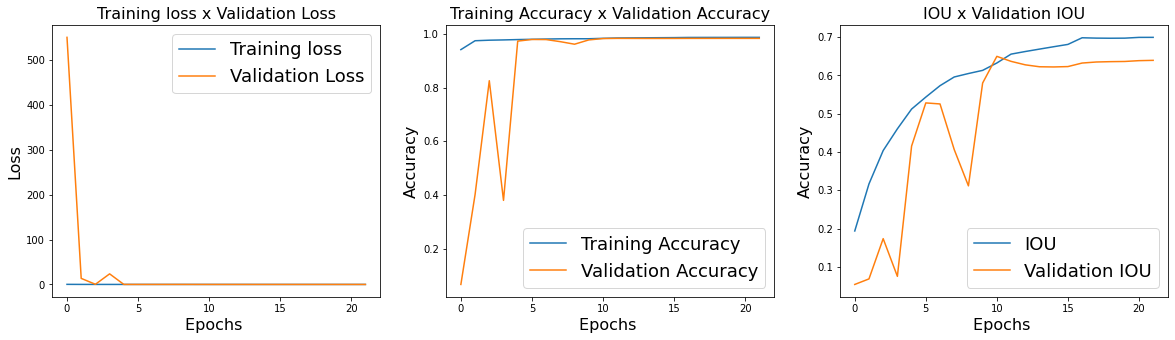

In [ ]:
hist(history)